In [1]:
import pandas as pd
import numpy as np
from dataloaders.finbert_dataloaders import ValDataset
import datetime

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.utils.data import DataLoader
from dataloaders.finbert_dataloaders import ValDataset
import torch.nn as nn
import matplotlib.pyplot as plt


/home/nickmoran/miniconda3/envs/st/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tweets = pd.read_csv("Tweet.csv")
company_tweet = pd.read_csv("Company_Tweet.csv")
aapl_tweet_ids = company_tweet[company_tweet['ticker_symbol'] == 'AMZN']
ids = aapl_tweet_ids['tweet_id'].tolist()
aapl_tweets = tweets[tweets['tweet_id'].isin(ids)]

In [3]:
aapl_tweets['post_date'] = pd.to_datetime(aapl_tweets['post_date'].apply(lambda x: datetime.datetime.fromtimestamp(x).isoformat()))
mask = (aapl_tweets['post_date'] >= pd.to_datetime(1514790000, unit='s')) & (aapl_tweets['post_date'] <= pd.to_datetime(1546239600, unit='s'))
time_tweets = aapl_tweets[mask]

/tmp/ipykernel_12772/2315667270.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aapl_tweets['post_date'] = pd.to_datetime(aapl_tweets['post_date'].apply(lambda x: datetime.datetime.fromtimestamp(x).isoformat()))


In [4]:
len(time_tweets), len(aapl_tweets)

(163420, 718715)

In [5]:
hour_mask = (time_tweets['post_date'].dt.hour >= 9) & (time_tweets['post_date'].dt.hour <= 11)
time_tweets = time_tweets[hour_mask]
len(time_tweets)

36216

In [6]:
gb_date = time_tweets.groupby(time_tweets.post_date.dt.strftime('%y-%m-%d'))  

In [7]:
num_tweets_per_day = gb_date.count()['tweet_id']
idx = list(gb_date.indices.keys())

In [8]:
m = num_tweets_per_day.rolling(20).mean()
s = num_tweets_per_day.rolling(20).std()

In [9]:
trading_days = num_tweets_per_day.to_numpy() > (m+s)

In [10]:
trading_date = np.array(idx)[trading_days == True]
len(trading_date)

55

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cuda':
    print('cleaning cache')
    torch.cuda.empty_cache()

In [12]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

# The model will give softmax outputs for three labels: positive, negative or neutral (in this order)
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
model = model.to(device=device)
model.eval()
print('ready!')

ready!


In [13]:
def maj_sent(news_articles):
    torch.cuda.empty_cache()        
    tokens_encoding = tokenizer(news_articles,max_length=64, padding='max_length', truncation=True, return_tensors="pt")
    val_loader = ValDataset(tokens_encoding)
    val_dataloader = DataLoader(val_loader, shuffle=False, batch_size=2)

    softmax = nn.Softmax(dim=1)
    
    mood = []

    for ids,attn_mask,ttype_ids in val_dataloader:
        ids = ids.to(device=device)
        attn_mask = attn_mask.to(device=device)
        ttype_ids = ttype_ids.to(device=device)

        output = model(input_ids=ids, attention_mask=attn_mask, token_type_ids=ttype_ids)
        output = softmax(output.logits)
     
        s = output.argmax(dim=1).cpu().numpy()
        s[s == 1] = -1
        s[s == 0] = 1
        s[s == 2] = 0

        mood.extend(s)

    return np.sign(sum(mood))


In [14]:
date_format = '%y-%m-%d'
date_format_chart = '%Y-%m-%d'

In [18]:
chart = pd.read_csv("./charts/AMAZON1440.csv")
chart['date'] = pd.to_datetime(chart['date'].apply(lambda x: datetime.datetime.strptime(x, date_format_chart)))

In [19]:
hourly_chart = pd.read_csv("./charts/AMAZON60.csv")
stock_time_format = '%H:%M'
dtime_gen = lambda x,y: datetime.datetime.combine(x,y.time())

# hourly_chart['time'] = hourly_chart['time'].apply(lambda x:  datetime.datetime.strptime(x, stock_time_format))
hourly_chart['date'] = hourly_chart['date'].apply(lambda x:  datetime.datetime.strptime(x, date_format_chart))

# hourly_chart['dtime'] = hourly_chart.apply(lambda x: dtime_gen(x.date, x.time), axis=1)

In [20]:
pred = []
ans = []
pnl = []
amt_twts = []

for i, d in enumerate(trading_date):
    date = datetime.datetime.strptime(d, date_format).strftime('%y-%m-%d')

    stk_mv = chart[chart['date'].dt.strftime('%y-%m-%d') == date]
    stk_mv_idx = chart[chart['date'].dt.strftime('%y-%m-%d') == date].index

    next_day = chart.iloc[stk_mv_idx[0] + 1]
    
    hr_start = hourly_chart[hourly_chart['date'].dt.strftime('%y-%m-%d') == date]
    hr_start = hr_start[hr_start['time'] == '15:30']
    
    #if the market isn't open
    if len(stk_mv) == 0:
        print('market closed', date, stk_mv,)
        break
    
    # direction = np.sign(stk_mv['close'].values - hr_start['open'].values)
    direction = np.sign(next_day['close'] - hr_start['open'].values)

    
    # pnl.append([hr_start['open'].values, stk_mv['close']])
    pnl.append([hr_start['open'].values[0], next_day['close']])

    
    mask = (time_tweets['post_date'].dt.strftime('%y-%m-%d') == date)
    daily_tweets = time_tweets[mask]

    gbtweets = daily_tweets.groupby(daily_tweets['post_date'].dt.hour)
    amt_twts.append(gbtweets.count())

    sent = maj_sent(daily_tweets['body'].tolist())
    
    ans.extend(direction)
    pred.append(sent)

acc = sum(np.array(pred) == np.array(ans)) / len(ans)
print('ACC:',acc)
# ACC: 0.82 (tweets full lookahead)
# ACC: 0.6666666666666666 (tweets no lookhead, cutoff @ 12pm)
# ACC: 0.5531914893617021 (tweets no lookhead, cutoff @ 2pm)
# ACC: 0.7555555555555555 (tweets no lookhead, cutoff @ 11am) (15:30 here, 11am in mask)
# ACC: 0.673469387755102 (tweets no lookhead, cutoff @ 10am) (14:30 here, 10am in mask)

ACC: 0.7090909090909091


Text(0.5, 0, 'hour')

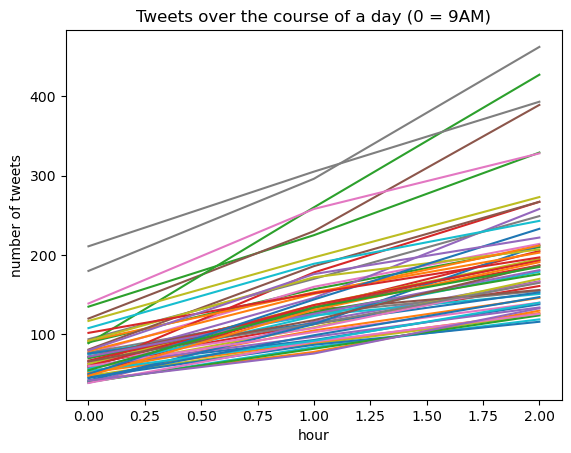

In [21]:
for day in amt_twts:
    t = day.tweet_id.tolist()
    c = np.cumsum(t)
    
    # if c.shape[0] != 3:
    #     continue
    plt.plot(c)

plt.title("Tweets over the course of a day (0 = 9AM)")
plt.ylabel("number of tweets")
plt.xlabel("hour")
    

In [22]:
pnl = np.array(pnl)
pnl2 = pnl
pnl

array([[1392.33, 1416.97],
       [1413.76, 1437.1 ],
       [1406.99, 1447.  ],
       [1461.6 , 1469.97],
       [1431.2 , 1429.84],
       [1474.3 , 1381.11],
       [1345.96, 1388.22],
       [1463.94, 1481.21],
       [1494.39, 1499.91],
       [1495.79, 1536.68],
       [1561.99, 1598.6 ],
       [1593.9 , 1587.5 ],
       [1398.  , 1443.97],
       [1420.01, 1371.5 ],
       [1381.7 , 1393.36],
       [1389.19, 1412.  ],
       [1482.18, 1474.5 ],
       [1598.91, 1568.  ],
       [1575.14, 1584.  ],
       [1622.01, 1630.7 ],
       [1629.72, 1641.7 ],
       [1643.29, 1665.56],
       [1651.29, 1694.13],
       [1683.  , 1695.49],
       [1716.26, 1715.93],
       [1750.87, 1728.25],
       [1666.98, 1690.  ],
       [1682.7 , 1698.76],
       [1784.18, 1812.56],
       [1811.03, 1795.98],
       [1825.67, 1846.6 ],
       [1838.3 , 1840.52],
       [1828.08, 1817.38],
       [1897.56, 1885.99],
       [1939.  , 1998.5 ],
       [1976.88, 2003.01],
       [2009.18, 2038.05],
 

In [23]:
delta = pnl2[:,1] - pnl2[:,0] #close - open 

In [24]:
win = np.array(pred)*delta
win

array([ 24.64,  23.34,  40.01,   8.37,   1.36, -93.19, -42.26,  17.27,
         5.52,  40.89,  36.61,  -6.4 , -45.97,  48.51, -11.66, -22.81,
         7.68, -30.91,   8.86,  -8.69,  11.98, -22.27,  42.84,  12.49,
         0.33, -22.62, -23.02, -16.06,  28.38,  15.05,  20.93,   2.22,
        10.7 , -11.57,  59.5 ,  26.13,  28.87, -50.08,  11.38,  59.06,
        52.63,  29.77,  21.38, -10.17,  82.5 ,  79.32, 110.12,  60.63,
       -28.75,  26.65,  61.79,  65.58,  14.53, 112.46,  85.18])

In [25]:
max(win),min(win), np.median(win), np.mean(win)

(112.46000000000004,
 -93.19000000000005,
 14.529999999999973,
 17.255090909090903)

In [26]:
def roi(starting, prec):
  ret = []

  for p in prec:
    cash = starting
    cost = 0
    r = [0]
    cash_arr = [starting]
    l = 0

    for i in range(len(win)):
      cash2trade = cash * p #percentage of the portfolio 

      stocks = cash2trade // pnl2[i][0]
      
      attmt = win[i] / pnl2[i][0]
      # if it goes down half a percent or more... cash out (stop loss)
      if attmt <= -0.005:
         r.append(r[-1] + -0.005)
         cash += -0.005*pnl2[i][0]*stocks
         cash_arr.append(cash_arr[-1]+-0.005*pnl2[i][0]*stocks)
         continue
            
      cash += win[i]*stocks
      cash_arr.append(cash_arr[-1]+ win[i]*stocks)


      r.append(r[-1] + (win[i])/(pnl2[i][0])) 
      
      if cash <= 0:
          break
    
    ret.append([r, cash-starting])
    # ret.append((cash-starting))


  return r, cash_arr

[0, 0.017696954026703512, 0.03420612107061473, 0.06264271265975181, 0.06836931364497356, 0.06931956518214526, 0.06431956518214525, 0.059319565182145255, 0.07111649675037891, 0.07481031161798374, 0.10214703669302777, 0.12558508687260633, 0.12156977850947183, 0.11656977850947182, 0.15073150976488553, 0.14573150976488553, 0.14073150976488552, 0.14591306666080914, 0.14091306666080913, 0.14653796349537615, 0.14153796349537615, 0.14888891948781657, 0.14388891948781657, 0.16983227286608454, 0.17725354440500316, 0.17744582296419578, 0.17244582296419578, 0.16744582296419577, 0.16244582296419577, 0.17835228980050144, 0.18666247792549107, 0.1981267622704164, 0.1993343997615767, 0.20518753529175035, 0.20018753529175035, 0.23087345586936767, 0.24409125361126394, 0.2584602996897636, 0.2534602996897636, 0.2592558364135028, 0.2886364360642787, 0.3154477127965939, 0.3309583336903433, 0.3422697249703082, 0.3372697249703082, 0.3827623689476336, 0.42853270939772015, 0.4956753662031393, 0.533554201411776, 

Text(0.5, 1.0, 'Daily PNL of trading AMAZON')

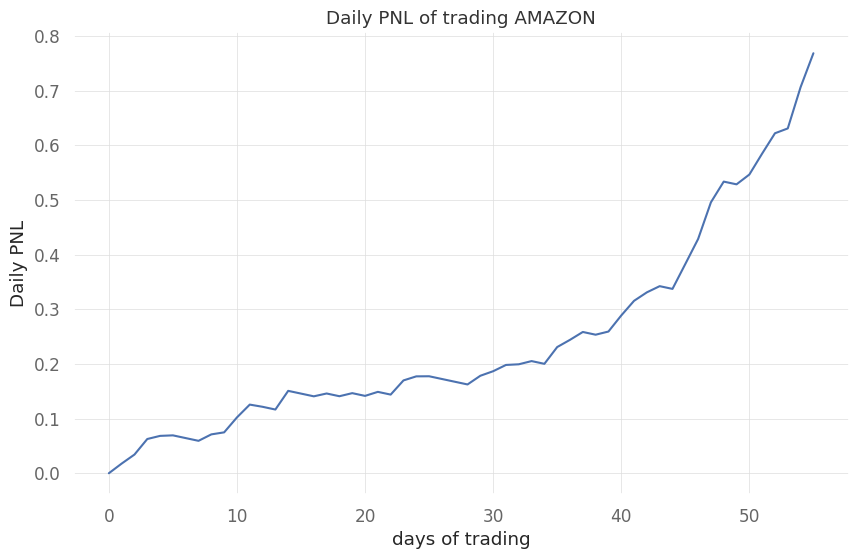

In [31]:
# prec = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
prec = [1]
rets, cash_arr = roi(5000, prec)
print(rets)
plt.plot(rets)
plt.ylabel('Daily PNL')
plt.xlabel('days of trading')
plt.title("Daily PNL of trading AMAZON")
# rets = np.array(rets)
# ret_df = pd.DataFrame(rets, columns=['ROI, investing $10000', 'Raw profit from investing $10000'], index=[str(p) for p in prec])
# ax = ret_df.plot.bar(subplots=True, color={"ROI, investing $10000": "blue", "Raw profit from investing $10000": "green"}, legend=False)

# plt.show()

In [28]:
import quantstats as qs

In [29]:
qs.stats.sharpe(pd.Series(rets))

20.822482712441314

In [30]:
rets[-1]

0.7683737748518455